In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [4]:
import sys, os
import warnings
import glob
sys.path.append('../')

from rankutils.mappings import ranking_type_map, exp_aliases
from rankutils.cfgloader import cfgloader
from rankutils.evaluation import Evaluator
from rankutils.drawing import colors_from_cmap

from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, confusion_matrix, average_precision_score, precision_score, f1_score

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

import mpld3

In [5]:
def evaluate(gtpath, predpath, k):
        
    gt = np.load(gtpath)
    p = np.load(predpath)
    
    if p.ndim == 2:
        r = p.shape[0]
        p = p.reshape(1, r, -1)
        
    nrounds = p.shape[0]
    
    bacc_eval = np.zeros((nrounds, k), dtype=np.float64)
    tpr_eval = np.zeros((nrounds, k), dtype=np.float64)
    tnr_eval = np.zeros((nrounds, k), dtype=np.float64)
    mcc_eval = np.zeros((nrounds, k), dtype=np.float64)
    ppv_eval = np.zeros((nrounds, k), dtype=np.float64)
    f1_eval = np.zeros((nrounds, k), dtype=np.float64)
    
    for r in range(nrounds):
        pr = p[r]
        
        for i in range(k):
            
            y_true = gt[:, i]
            y_pred = pr[:, i]
            
            bacc_eval[r, i] = balanced_accuracy_score(y_true, y_pred)
            mcc_eval[r, i] = matthews_corrcoef(y_true, y_pred)
            
            cfmat = confusion_matrix(y_true, y_pred).ravel()
            if cfmat.size > 1:
                tn, fp, fn, tp = cfmat.ravel()
                tpr_eval[r, i] = tp/(tp + fn)
                tnr_eval[r, i] = tn/(tn + fp)
            else:
                if y_true[0] == 1:
                    tpr_eval[r, i] = 1.0
                    tnr_eval[r, i] = 1.0
            
            ppv_eval[r, i] = precision_score(y_true, y_pred)
            f1_eval[r, i] = f1_score(y_true, y_pred)
            
    return bacc_eval, tpr_eval, tnr_eval, mcc_eval, ppv_eval, f1_eval

In [6]:
def per_sample_evaluate(gtpath, predpath, k, spos=0):
    
    gt = np.load(gtpath)
    p = np.load(predpath)
    
    if p.ndim == 2:
        s = p.shape[0]
        p = p.reshape(1, s, -1)
        
    nrounds = p.shape[0]
    s = p.shape[1]
    
    sample_bacc_eval = np.zeros((nrounds, s), dtype=np.float64)
    sample_acc_eval = np.zeros((nrounds, s), dtype=np.float64)
    sample_ap_eval = np.zeros(s, dtype=np.float64)
    sample_prec_eval = np.zeros(s, dtype=np.float64)
    
    for r in range(nrounds):
        pr = p[r]
        
        for i in range(s):
            
            y_true = gt[i, spos:k]
            y_pred = pr[i, spos:k]
            
            sample_bacc_eval[r, i] = balanced_accuracy_score(y_true, y_pred)
            sample_acc_eval[r, i] = np.sum(y_pred == y_true)/y_true.size
            
            if r == 0:
                sample_ap_eval[i] = average_precision_score(y_true, np.arange(y_true.size, 0, -1))
                sample_prec_eval[i] = np.sum(y_true)/y_true.size
                
    return sample_bacc_eval, sample_acc_eval, sample_ap_eval, sample_prec_eval

In [7]:
def plot_results(ax, results, k, title, draw_legend):
    
    ax.set_title(title, fontdict=dict(fontsize=14, horizontalalignment='center'))
    
    handles = []
    labels = []
    
    bacc, tpr, tnr, mcc, ppv, f1 = results
    
    x = np.arange(1, k+1).astype(np.int32)
        
    line, = ax.plot(x, np.mean(bacc, axis=0), color=colors_from_cmap('Purples', 0.7)[0], marker='s')
    handles.append(line)
    labels.append('Balanced Acc.')
    
    line, = ax.plot(x, np.mean(tpr, axis=0), color=colors_from_cmap('Blues', 0.7)[0], marker='o')
    handles.append(line)
    labels.append('True Pos. Rate')
    
    line, = ax.plot(x, np.mean(tnr, axis=0), color=colors_from_cmap('Reds', 0.7)[0], marker='o')
    handles.append(line)
    labels.append('True Neg. Rate')
    
    line, = ax.plot(x, np.mean(mcc, axis=0), color=colors_from_cmap('Greens', 0.7)[0], marker='X')
    handles.append(line)
    labels.append('Matthews Corr. Coef.')
    
    line, = ax.plot(x, np.mean(ppv, axis=0), color=colors_from_cmap('Oranges', 0.7)[0], marker='d')
    handles.append(line)
    labels.append('PPV.')
    
    line, = ax.plot(x, np.mean(f1, axis=0), color=colors_from_cmap('Greys', 0.7)[0], marker='^')
    handles.append(line)
    labels.append('F1.')
        
    if draw_legend:
        ax.legend(handles, labels, fancybox=True, shadow=True, loc='best', ncol=1, fontsize='large')

        
    ax.set_ylim(bottom=-1.0, top=1.0)
    ax.set_yticks([y for y in np.arange(-1.0, 1.1, 0.2)])
    ax.set_yticklabels(["{0:0.1f}".format(y) for y in np.arange(-1.0, 1.1, 0.2)], fontdict=dict(fontsize=12))
    ax.set_ylabel('Measure Value', fontdict=dict(fontsize=12))

    ax.set_xlim(left=1.0, right=k)
    ax.set_xticks([x for x in np.arange(1, k + 1, 1)])
    ax.set_xticklabels(["{0:d}".format(x) for x in np.arange(1, k + 1, 1)], fontdict=dict(fontsize=8))
    ax.set_xlabel('Rank Position', fontdict=dict(fontsize=12))

In [8]:
pathcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/path_2.cfg")
evalcfgfile = "/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/evalcfg/thesis/0001.eval_stat.cfg"
barfigsize=(20, 8)
linefigsize=(15, 15)
titleargs=dict(fontsize=14, horizontalalignment='center')
k=10
method='pos-learn.0006.irp.cid-jaccard-20-100.k30.svc'
method_label="$AccJacc$"
#modmethod = '80pct'

In [9]:
results_p = dict()
#results_m = dict()

keys = []
#keys += ['oxford_001', 'oxford_002', 'oxford_003', 'oxford_004', 'oxford_005']
#keys += ['unicamp_001', 'unicamp_002', 'unicamp_003', 'unicamp_004', 'unicamp_005']
#keys += ['corel_001', 'corel_002']
#keys += ['places365_001', 'places365_002', 'places365_003']
#keys += ['vggfaces_001', 'vggfaces_002']
keys += ['imagenet_001', 'imagenet_002', 'imagenet_003']


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for key in tqdm(keys, desc='Evaluating Key ', total=len(keys)):
        rktpdir = pathcfg.get(key, 'rktpdir')
        
        gtpath = glob.glob("{0:s}/*{1:s}*".format(pathcfg.get(key, 'label'), rktpdir))[0]
        #print("{0:s}/{1:s}/{2:s}/*irp.npy".format(pathcfg.get(key, 'output'), rktpdir, method))
        predpath = glob.glob("{0:s}/{1:s}/*irp.npy".format(pathcfg.get(key, 'output'), method))[0]
        
        results_p[key] = evaluate(gtpath, predpath, k)
        
        dset, num = key.split("_", 1)
        #modpath = glob.glob("{0:s}/{1:s}/{2:s}/*{3:s}*".format(pathcfg.get('DEFAULT', 'agglbldir'), dset, modmethod, num))[0]
        
        #results_m[key] = evaluate(gtpath, modpath, k)
        

# Positional Evaluation

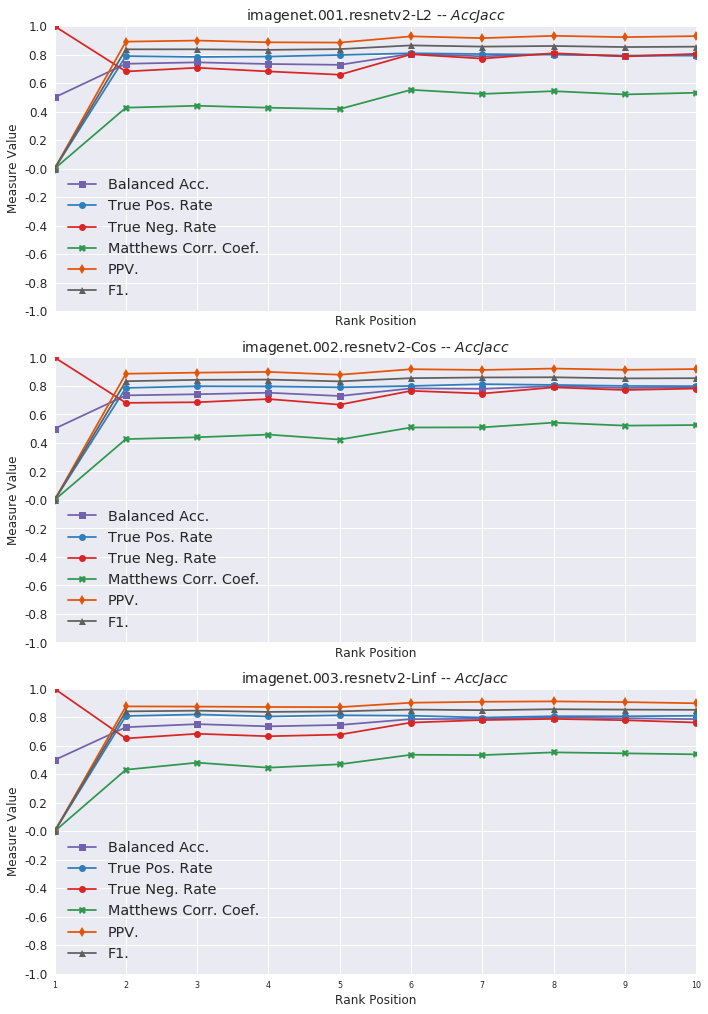

In [10]:
fig_c = 1
fig_r = int(np.ceil(len(keys)/fig_c))

fig, axes = plt.subplots(fig_r, fig_c, sharex=True)
axes = axes.reshape(-1)
fig.set_size_inches((10, fig_r*5))

print(axes)

for i, key in enumerate(keys):
    
    axA = axes[i]
    
    plot_results(axA, results_p[key], k, "{0:s} -- {1:s}".format(exp_aliases[key], method_label), True)
    #plot_results(axB, results_m[key], k, "{0:s} -- {1:s}".format(aliases[key], modmethod),  True)
            

fig.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig('/home/alberto/Dropbox/ICASSP-2019_ML_Relevance_Prediction/tex/figures/ICASSP_2019_Pos-NACC.svg')

# Correlation -- Rank-k bACC & AP